# Evaluation of Machine Learning Methods

##### Prediction of the metal ion content from multi-parameter data
<b> Use K-Nearest Neighbor Regression with euclidean distance to predict total metal concentration (c_total), concentration of Cadmium (Cd) and concentration of Lead (Pb), using number of neighbors k = 1, 3, 5, 7.</b>

    - You may use Nearest Neighbor Regression from https://scikit-learn.org/stable/modules/neighbors.html   
    - Implement Leave-One-Out cross-validation and calculate the C-index for each output (c_total, Cd, Pb). 
    - Implement Leave-Replicas-Out cross-validation and calculate the C-index for each output (c_total, Cd, Pb).

## Import libraries

In [8]:
# In this cell import all libraries you need. For example: 
import numpy as np
import pandas as pd
from scipy.stats import somersd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
import matplotlib.pyplot as plt

## Read and visualize the dataset

<p> <b>Note:</b> This dataset differs slightly from the one used in the video lectures. <br>
<b>In this dataset, some mixtures have 3 replicas, while others have 4 replicas. </b> </p> 

In the following cell: 
- Read the file water_data.csv
- Print the dimesions of the dataset (i.e. number of rows and columns) and display the first 5 rows.
- Identify the inputs and the outputs columns.
- Provide the number of mixtures with 3 replicas and 4 replicas, respectively.

In [91]:
water_data = pd.read_csv("water_data.csv")

print(f"Dataset dimensions: {water_data.shape}")
print(water_data.head())

input_columns = water_data.columns[-3:]
output_columns = water_data.columns[:3]

print("\nInput columns:", list(input_columns))
print("Output columns:", list(output_columns))

# Grouping the output columns and counting occurrences
replica_counts = water_data.groupby(list(output_columns)).size()

num_3_replicas = (replica_counts == 3).sum()
num_4_replicas = (replica_counts == 4).sum()

print(f"\n3 replicas: {num_3_replicas}")
print(f"4 replicas: {num_4_replicas}")

Dataset dimensions: (225, 6)
   c_total   Cd    Pb      Mod1      Mod2      Mod3
0      0.0  0.0   0.0 -0.999216 -0.714208 -0.414911
1      0.0  0.0   0.0 -0.990800 -0.714373 -0.238335
2      0.0  0.0   0.0 -0.990539 -0.714125  0.020788
3     14.0  0.0  14.0 -1.001247 -0.713546  0.945465
4     14.0  0.0  14.0 -1.013727 -0.714125  0.569631

Input columns: ['Mod1', 'Mod2', 'Mod3']
Output columns: ['c_total', 'Cd', 'Pb']

3 replicas: 43
4 replicas: 24


## C-index code 

In [18]:
# In this cell is the fuction that computes the c-index value based on Somers'D statistic.
# Use this fuction as the evaluation metric in the Leave-One-Out (LOOCV) and Leave-Replicas-Out (LROCV) cross-validation methods.

def cindex(true, pred):
    s_d = somersd(true, y=pred, alternative='two-sided')
    c_index = (s_d.statistic + 1.0)/2.0
    return c_index

## Functions

**LOOCV Method References:**
1. https://www.statology.org/leave-one-out-cross-validation-in-python/
2. Data Analysis and Knowledge Discovery course material

**LROCV Method References:**
1. Lecture slides: MOOC 2: Module 2: Leave-group-out for concentration prediction

In [83]:
# Method for Leave-One-Out-Cross-Validation
def loocv(water_data, input_columns, output_columns):
    loo = LeaveOneOut()

    results_loocv = {}

    # This loops over each target variable
    for target in output_columns:
        X = water_data[input_columns].values
        y = water_data[target].values
        
        for k in [1, 3, 5, 7]:
            y_true = []
            y_pred = []
            
            for train_idx, test_idx in loo.split(X):
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]
                
                knn = KNeighborsRegressor(n_neighbors=k, metric="euclidean")
                knn.fit(X_train, y_train)
                
                pred = knn.predict(X_test)[0]
                
                y_true.append(y_test[0])
                y_pred.append(pred)
            
            # Now we will call cindex method to compute C-index
            c_idx = cindex(y_true, y_pred)
            
            results_loocv[(target, k)] = {"C-index": c_idx}
    
    # To display results in a readable table format
    print(f"{'Target':<10} {'k':<5} {'C-index':<10}")
    print("=" * 35)
    
    for (target, k), metrics in results_loocv.items():
        print(f"{target:<10} {k:<5} {metrics['C-index']:<10.4f}")

    return results_loocv

def lrocv(water_data, input_columns, output_columns):
    # First we will find replicas that we need to exclude from the analysis
    replica_groups = water_data.groupby(list(output_columns)).indices  
    
    results_lrocv = {}

    for target in output_columns:
        X = water_data[input_columns].values
        y = water_data[target].values
        
        for k in [1, 3, 5, 7]:
            y_true = []
            y_pred = []
            
            for output_values, indices in replica_groups.items():
    
                train_idx = np.setdiff1d(np.arange(len(water_data)), indices)
                test_idx = np.array(indices)

                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]
                
                
                knn = KNeighborsRegressor(n_neighbors=k, metric="euclidean")
                knn.fit(X_train, y_train)
                
                
                pred = knn.predict(X_test)
                
                
                y_true.extend(y_test)
                y_pred.extend(pred)
            
            # Now we will call cindex method to compute C-index
            c_idx = cindex(y_true, y_pred)
            
            results_lrocv[(target, k)] = {"C-index": c_idx}
    
    # To display results in a readable table format
    print(f"{'Target':<10} {'k':<5} {'C-index':<10}")
    print("=" * 35)
    
    for (target, k), metrics in results_lrocv.items():
        print(f"{target:<10} {k:<5} {metrics['C-index']:<10.4f}")

    return results_lrocv
        
def plot_cv_results(results_loocv, results_lrocv):
    targets_loocv = list(set([target for target, _ in results_loocv.keys()]))
    targets_lrocv = list(set([target for target, _ in results_lrocv.keys()]))
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Ploting LOOCV results
    axes[0].set_title('LOOCV')
    axes[0].set_xlabel('k value')
    axes[0].set_ylabel('C-index')
    axes[0].grid(True)
    
    for target in targets_loocv:
        k_values = [k for t, k in results_loocv.keys() if t == target]
        c_index_values = [results_loocv[(target, k)]['C-index'] for k in k_values]
        
        axes[0].plot(k_values, c_index_values, label=target, marker='o')
    
    axes[0].legend(title='Target Variables')

    # Ploting LROCV results
    axes[1].set_title('LROCV')
    axes[1].set_xlabel('k value')
    axes[1].set_ylabel('C-index')
    axes[1].grid(True)
    
    for target in targets_lrocv:
        k_values = [k for t, k in results_lrocv.keys() if t == target]
        c_index_values = [results_lrocv[(target, k)]['C-index'] for k in k_values]
        
        axes[1].plot(k_values, c_index_values, label=target, marker='o')
    
    axes[1].legend(title='Target Variables')

    plt.tight_layout()
    plt.show()

## Results for Leave-One-Out cross-validation

In [85]:
# method call to perform LOOCV and print c-index 
results_loocv = loocv(water_data, input_columns, output_columns)

Target     k     C-index   
c_total    1     0.9083    
c_total    3     0.9142    
c_total    5     0.8941    
c_total    7     0.8737    
Cd         1     0.9219    
Cd         3     0.8996    
Cd         5     0.8620    
Cd         7     0.8142    
Pb         1     0.8805    
Pb         3     0.8745    
Pb         5     0.8543    
Pb         7     0.8355    


## Results for Leave-Replicas-Out cross-validation

In [87]:
# method call to perform LROCV and print c-index
results_lrocv = lrocv(water_data, input_columns, output_columns)

Target     k     C-index   
c_total    1     0.8184    
c_total    3     0.8187    
c_total    5     0.8117    
c_total    7     0.8164    
Cd         1     0.7784    
Cd         3     0.7615    
Cd         5     0.7397    
Cd         7     0.7153    
Pb         1     0.7378    
Pb         3     0.7689    
Pb         5     0.7478    
Pb         7     0.7618    


## Plot Leave-One-Out and Leave-Replicas-Out Results

Note: You may plot the results as they were presented in the video lecture (refer to MOOC2-Module 2 .pptx slides).

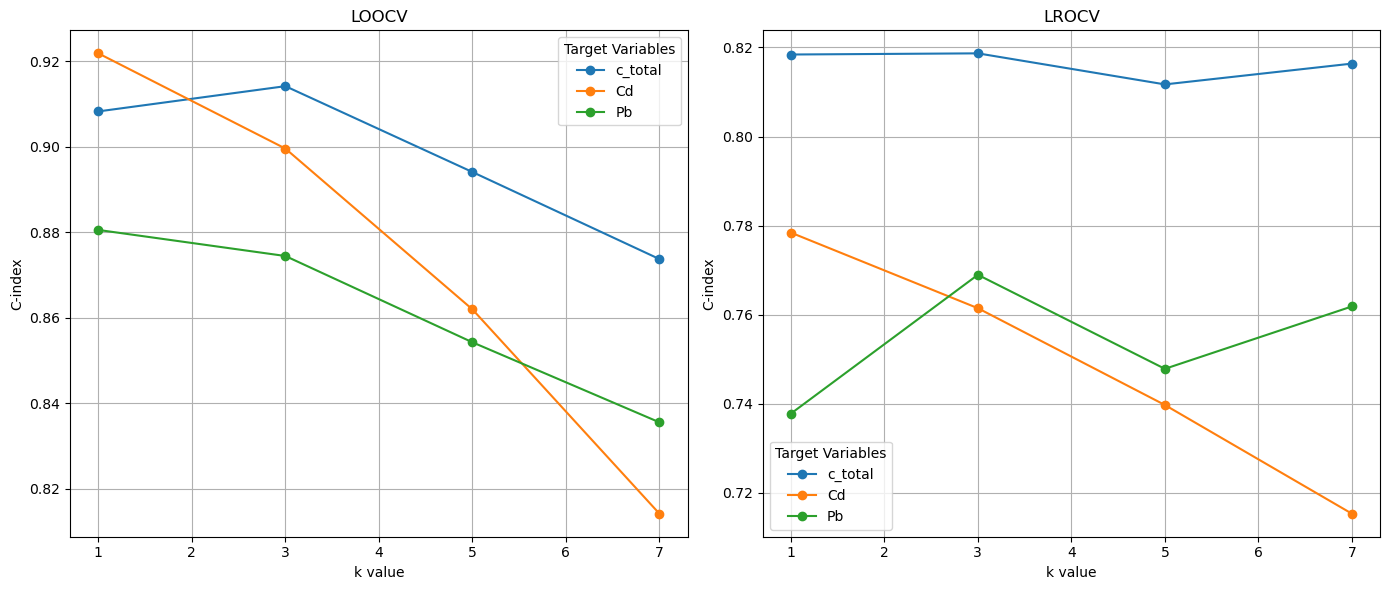

In [89]:
# method call to plot results of LOOCV and LROCV respectively
plot_cv_results(results_loocv, results_lrocv)

## Interpretation of results
#### Answer the following questions based on the results obtained
1. Which cross-validation approach produced more optimistic results, and why?
2. Which cross-validation method provides a better estimate of the model's performance on unseen mixtures? Explain your answer.

#### Answers:
1. The LOOCV approach produced more better results compared to the LROCV because the c-index values in the LOOCV output are generally higher across all target variables and for all values of `k` as compared to the LROCV results. LOOCV provides more better estimates of model performance because each test set consists of a single sample, which is often easier for the model to predict accurately. On the other hand, LROCV where the model left out entire replicas. It means that this can lead to more challenging test sets which will result in lower c-index values. This difference shows how LOOCV may overestimate a model’s performance, especially in cases where the model may not generalize well to more complex or diverse test sets, as seen in the LROCV results.
2. The LROCV provides a better estimate of the model's performance on unseen mixtures. This is because LROCV simulates more closely, the real-world scenarios where the model must generalize to entirely new groups or mixtures of samples that are not seen during training. Moreover, all the replicas are left out during the validation process, to make sure that the model is tested on mixtures that were not part of the training set. This results in a more challenging and realistic evaluation of the model’s ability to generalize. LOOCV can lead to overly optimistic estimates of performance because the model tests on individual samples when the dataset contains repeated patterns or homogeneous mixtures. Since LOOCV splits the data as one sample at a time, it may fail to properly evaluate the model's generalization to new, unseen mixtures. Therefore, LROCV is a more robust and reliable method for assessing the true performance of the model when applied to unseen data.